In [478]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lightgbm import LGBMRegressor
import lightgbm
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px

In [207]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [210]:
btc_df = pd.read_parquet("data/BTCUSDT.pq")
btc_df = btc_df.sort_values(by = "time")
btc_df["return"] = btc_df["close"] - btc_df["close"].shift(1)
# btc_df["return"] = np.log(btc_df['close']/btc_df['close'].shift(1))
btc_df = btc_df.drop(btc_df.index[0])
btc_df.reset_index(inplace=True)

train_time = pd.to_datetime("09/01/24")

if not os.path.exists("market_neutral/"):
    os.mkdir("market_neutral/")

for filename in os.listdir("data/"):
    if filename.endswith(".pq") and filename != "BTCUSDT.pq":
        x_df = pd.read_parquet(os.path.join("data/", filename))
        x_df = x_df.sort_values(by = "time")
        x_df["return"] = x_df["close"] - x_df["close"].shift(1)
        x_df = x_df.drop(x_df.index[0])

        if (x_df.shape[0] != btc_df.shape[0]) or (not all(btc_df.time.values == x_df.time.values)):
            # print(f"Times dont add up for file {filename}")
            continue
        
        X = btc_df["return"][btc_df["time"] < train_time].values.reshape(-1, 1)
        y = x_df["return"][x_df["time"] < train_time].values

        model = LinearRegression().fit(X, y)

        # print(f"Linear regression between BTC and {filename}:")
        # print(f"Slope (Beta): {model.coef_[0]}")
        # print(f"Intercept: {model.intercept_}")

        MN_x = x_df.copy()
        columns = ["return"]
        MN_x["return"] = x_df["return"] - model.coef_[0] * btc_df["return"]
        MN_x["mn_close"] = x_df["close"] - model.coef_[0] * btc_df["close"]
        MN_x = MN_x.loc[:,["time", "close", "mn_close", "return", "volume", "turnover"]] #makes above line a little reundant
        MN_x.reset_index(drop=True, inplace=True)
        
        MN_x.to_parquet(f"market_neutral/MN_{filename[:-3]}.pq")

In [211]:
print(btc_df.head())
print(mn_silly.head())

   index                time     open     high      low    close  volume  \
0  35135 2024-06-01 00:05:00  67783.2  67783.3  67742.0  67782.9  66.236   
1  35134 2024-06-01 00:10:00  67782.9  67782.9  67730.7  67730.8  37.948   
2  35133 2024-06-01 00:15:00  67730.8  67748.4  67681.3  67711.2  56.923   
3  35132 2024-06-01 00:20:00  67711.2  67723.9  67694.2  67714.1  28.580   
4  35131 2024-06-01 00:25:00  67714.1  67716.3  67695.4  67715.5  36.457   

       turnover  return  
0  4.488159e+06    -0.3  
1  2.571165e+06   -52.1  
2  3.854043e+06   -19.6  
3  1.935110e+06     2.9  
4  2.468367e+06     1.4  
                     mn_close    return    volume         y     ema10  \
time                                                                    
2024-06-01 00:20:00 -0.001707 -0.000041  340964.0  0.000063 -0.000100   
2024-06-01 00:25:00 -0.001644  0.000063  252645.0  0.000042 -0.000026   
2024-06-01 00:30:00 -0.001602  0.000042  169363.0  0.000165  0.000012   
2024-06-01 00:35:00 -0

In [495]:
mn_silly = pd.read_parquet("market_neutral/MN_SILLYUSDT.pq")
mn_silly.set_index("time", inplace=True)

mn_silly["y"] = (mn_silly["mn_close"].shift(-1)-mn_silly["mn_close"])/np.abs(mn_silly["mn_close"])
mn_silly["ema10"] = mn_silly["mn_close"] - mn_silly["mn_close"].ewm(span=10).mean()
mn_silly["ema100"] = mn_silly["mn_close"] - mn_silly["mn_close"].ewm(span=100).mean()
mn_silly["ema1000"] = mn_silly["mn_close"] - mn_silly["mn_close"].ewm(span=1000).mean()
mn_silly["1p_lag"] = mn_silly["return"].shift(1)
mn_silly["2p_lag"] = mn_silly["return"].shift(2)
mn_silly["3p_lag"] = mn_silly["return"].shift(3)
mn_silly.drop(columns=["turnover", "close"], inplace=True)
mn_silly = mn_silly.dropna()
mn_silly.head()

,mn_close,return,volume,y,ema10,ema100,ema1000,1p_lag,2p_lag,3p_lag
time,,,,,,,,,,
2024-06-01 00:20:00,-0.001707,-0.000041,340964.0,0.037081,-0.000100,-0.000122,-0.000124,-0.000121,-0.000132,0.000060
2024-06-01 00:25:00,-0.001644,0.000063,252645.0,0.025273,-0.000026,-0.000046,-0.000048,-0.000041,-0.000121,-0.000132
2024-06-01 00:30:00,-0.001602,0.000042,169363.0,0.103222,0.000012,-0.000004,-0.000006,0.000063,-0.000041,-0.000121
2024-06-01 00:35:00,-0.001437,0.000165,151269.0,-0.058604,0.000134,0.000137,0.000137,0.000042,0.000063,-0.000041
2024-06-01 00:40:00,-0.001521,-0.000084,239452.0,0.109306,0.000039,0.000046,0.000046,0.000165,0.000042,0.000063


LGBM Train MSE: 0.005796305461017953
LGBM Test MSE: 0.00021427994979838062
Linear Train MSE: 0.011600804616325927
Linear Test MSE: 8.388127463793847e-05
LGBM Correctness: 0.5941659914341938
Linear Correctness: 0.5431184164833893


/var/folders/mf/j0jd6xtx3v15f0xj48w9cf8h0000gn/T/ipykernel_45854/3823556503.py:41: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



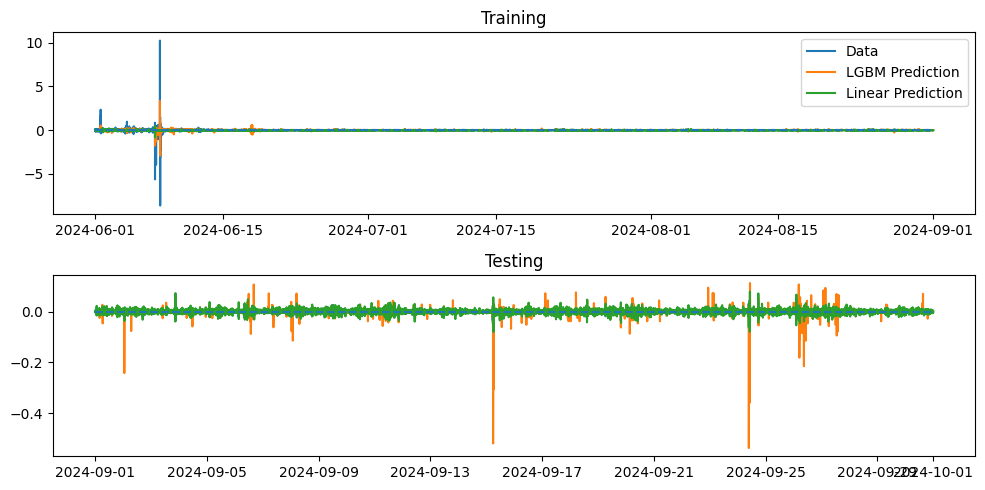

In [498]:
X = mn_silly
X = X.drop(columns="mn_close")
X_train = X[X.index < train_time]
y_train = X_train["y"]
X_train = X_train.drop(columns=["y"])
X_test = X[X.index >= train_time]
y_test = X_test["y"]
X_test = X_test.drop(columns=["y"])

# params = {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 1.0, "verbose":-1}
params = {"verbose":-1}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train_linear = linear_model.predict(X_train)
y_pred_test_linear = linear_model.predict(X_test)

print(f"LGBM Train MSE: {mean_squared_error(y_pred_train, y_train)}")
print(f"LGBM Test MSE: {mean_squared_error(y_pred_test, y_test)}")

print(f"Linear Train MSE: {mean_squared_error(y_pred_train_linear, y_train)}")
print(f"Linear Test MSE: {mean_squared_error(y_pred_test_linear, y_test)}")

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,5))
ax[0].plot(y_train)
ax[0].plot(y_train.index, y_pred_train)
ax[0].plot(y_train.index, y_pred_train_linear)
ax[0].set_title("Training")
ax[0].hlines(0, y_train.index.min(), y_train.index.max(), linestyles="dashed")
ax[1].set_title("Testing")
ax[1].plot(y_test)
ax[1].plot(y_test.index, y_pred_test)
ax[1].plot(y_test.index, y_pred_test_linear)
ax[1].hlines(0, y_test.index.min(), y_test.index.max(), linestyles="dashed")
ax[0].legend(["Data", "LGBM Prediction", "Linear Prediction"])
fig.tight_layout()
fig.show()

print(f"LGBM Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test))/y_test.shape[0]}")
print(f"Linear Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test_linear))/y_test.shape[0]}")

In [483]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = LGBMRegressor(**{"verbose": -1})

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid,
                                   n_iter=100, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {-random_search.best_score_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, min_child_samples=40, n_estimators=200, num_leaves=31, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, min_child_samples=30, n_estimators=100, num_leaves=100, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, min_child_samples=40, n_estimators=200, num_leaves=31, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, min_child_samples=40, n_estimators=200, num_leaves=31, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, min_child_samples=30, n_estimators=100, num_leaves=100, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=31, subsample=1.0; total time=   5.8s
[CV] END col

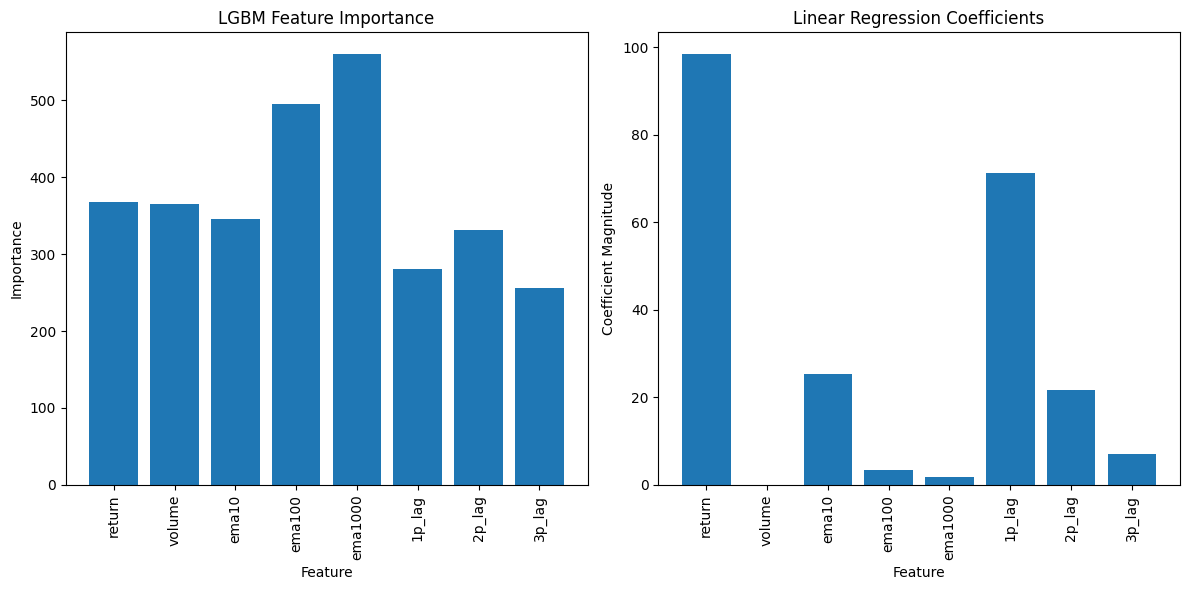

In [384]:
feature_names = X_train.columns  # Assuming X_train is a DataFrame. If not, provide a list of names manually.

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# LGBM Feature Importance
ax[0].bar(feature_names, lgbm_model.feature_importances_)
ax[0].set_title("LGBM Feature Importance")
ax[0].set_xlabel("Feature")
ax[0].set_ylabel("Importance")
ax[0].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

# Linear Regression Feature Importance (Absolute value of coefficients)
ax[1].bar(feature_names, np.abs(linear_model.coef_))
ax[1].set_title("Linear Regression Coefficients")
ax[1].set_xlabel("Feature")
ax[1].set_ylabel("Coefficient Magnitude")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [486]:
mn_silly = pd.read_parquet("market_neutral/MN_SILLYUSDT.pq")
mn_silly.set_index(mn_silly.time, inplace=True)
mn_silly = mn_silly.sort_index()


prediction = pd.DataFrame(index = X_test.index)
prediction["pred"] = y_pred_test
prediction["pred_linear"] = y_pred_test_linear
mn_silly[["pred", "pred_linear"]] = prediction
mn_silly = mn_silly[mn_silly.time >= train_time]


spread = 0.0012 + 0.00055
mn_silly["next_change"] = mn_silly["mn_close"].shift(-1) - mn_silly["mn_close"]
mn_silly["change"] = np.where(np.abs(mn_silly["pred"]) > 0.0016, np.where(mn_silly["pred"] > 0, mn_silly["next_change"], -mn_silly["next_change"]) - spread * mn_silly["close"], 0)
mn_silly["pl"] = mn_silly["change"].cumsum()

mn_silly["change_linear"] = np.where(np.abs(mn_silly["pred_linear"]) > 0.0001, np.where(mn_silly["pred_linear"] > 0, mn_silly["next_change"], -mn_silly["next_change"]) - spread * mn_silly["close"], 0)
mn_silly["pl_linear"] = mn_silly["change_linear"].cumsum()
print(mn_silly["pl"].iloc[-3])
print(mean := np.mean(mn_silly["change"][mn_silly["change"]!=0]))
print(std := np.std(mn_silly["change"][mn_silly["change"]!=0]))
print(sharpe := mean/std)

0.006282662009642653


In [432]:
print(mn_silly["change"])

time
2024-09-01 00:00:00    0.0
2024-09-01 00:05:00    0.0
2024-09-01 00:10:00    0.0
2024-09-01 00:15:00    0.0
2024-09-01 00:20:00    0.0
                      ... 
2024-09-30 23:40:00    0.0
2024-09-30 23:45:00    0.0
2024-09-30 23:50:00    0.0
2024-09-30 23:55:00    0.0
2024-10-01 00:00:00    0.0
Name: change, Length: 8641, dtype: float64


In [492]:
print(mean := np.mean(mn_silly["change"][mn_silly["change"]!=0]))
print(std := np.std(mn_silly["change"][mn_silly["change"]!=0]))
print(mean/std)

7.727751549375961e-06
0.00010017835894196644
0.07713992953161336


In [500]:
print(mn_silly["mn_close"][-1])

-0.014645605805354655


/var/folders/mf/j0jd6xtx3v15f0xj48w9cf8h0000gn/T/ipykernel_45854/1881337809.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



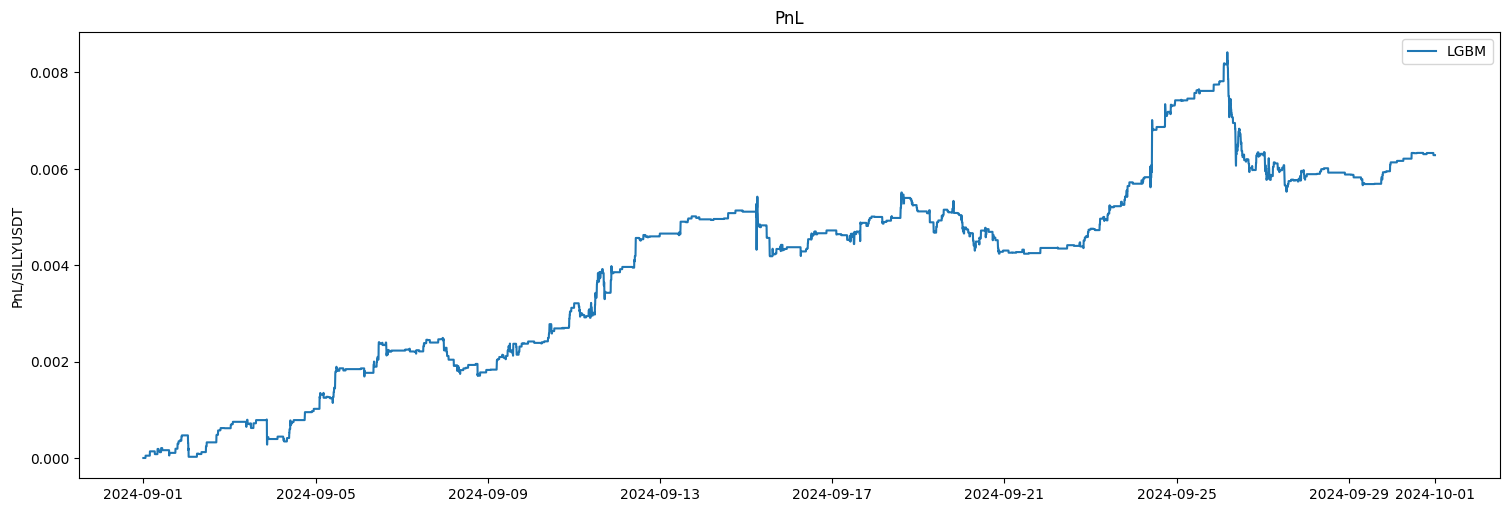

In [487]:
plt.figure(figsize=(15,5))
plt.plot(mn_silly["pl"])
# plt.plot(mn_silly["pl_linear"])
plt.tight_layout()
plt.ylabel("PnL/SILLYUSDT")
plt.title("PnL")
plt.legend(["LGBM", "Linear"])
plt.show()

Text(0.5, 1.0, 'MN_SILLY Close')

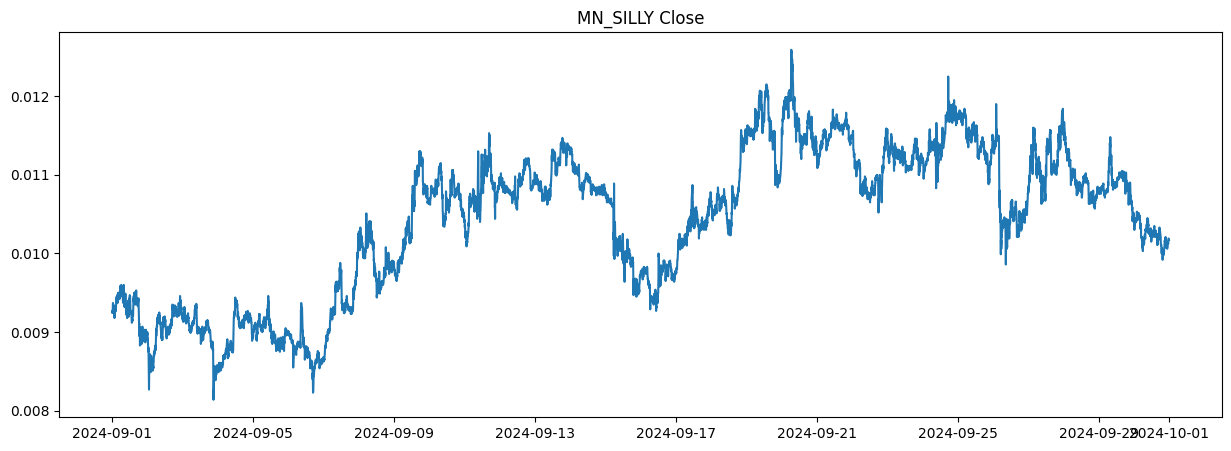

In [396]:
plt.figure(figsize=(15,5))
plt.plot(mn_silly["close"])
plt.title("MN_SILLY Close")

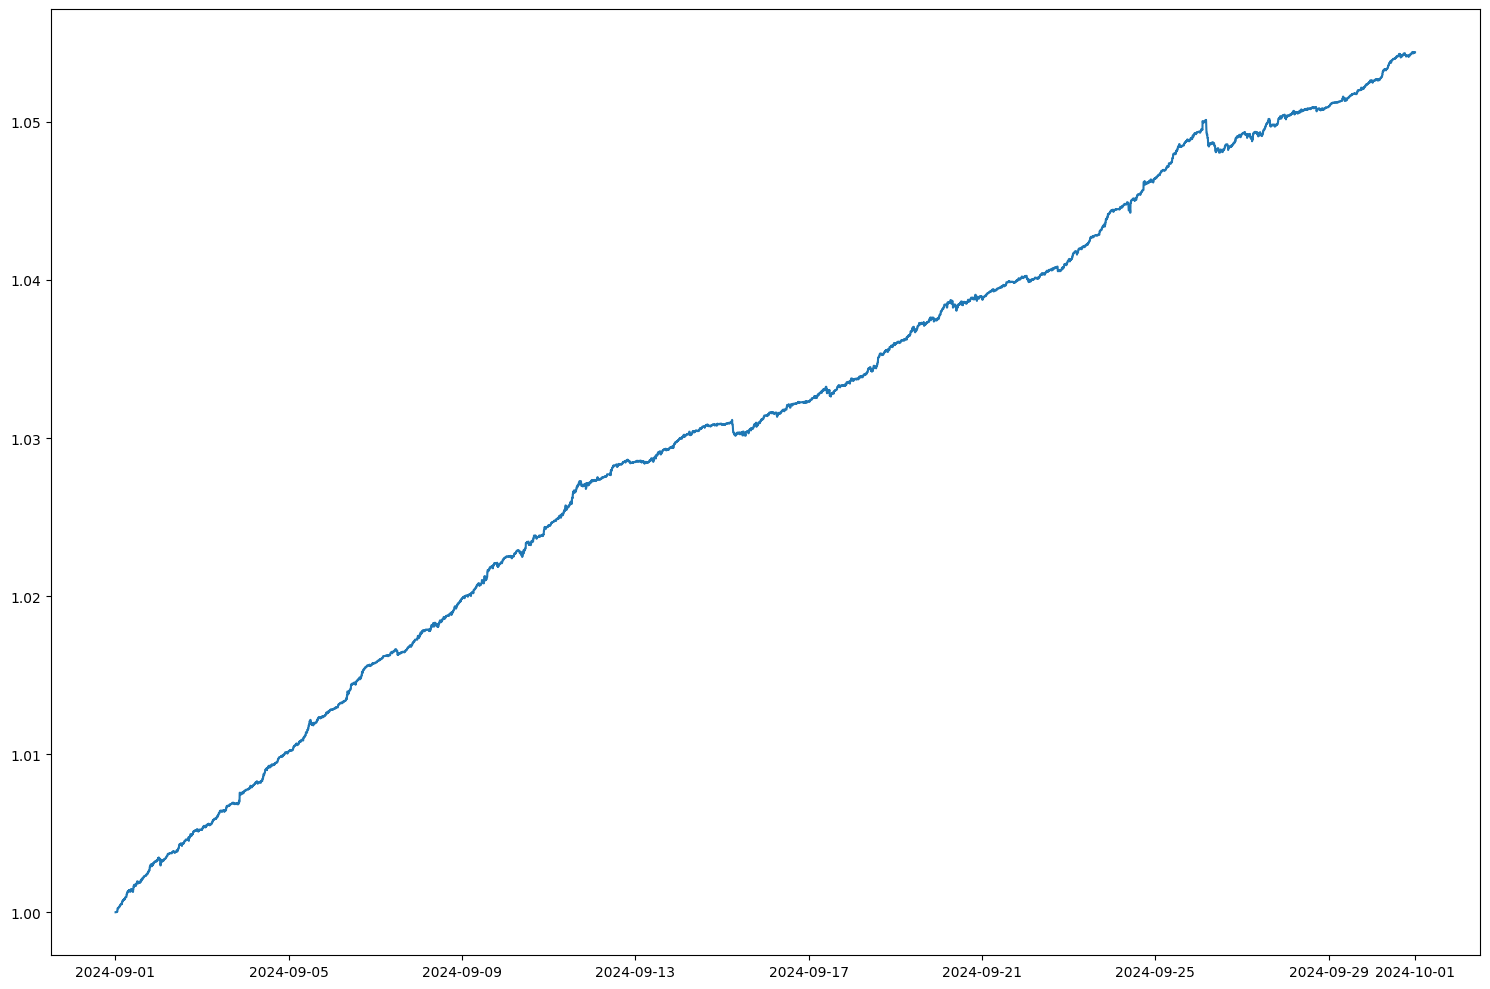

In [122]:
plt.figure(figsize=(15,10))
plt.plot(X.index[X.index > train_time], p_l[1:])
plt.tight_layout()
plt.show()